In [1]:
!curl http://localhost:8080/v1/models

curl: (7) Failed to connect to localhost port 8080 after 0 ms: Could not connect to server


In [2]:
import sys
sys.path.insert(0, '/home/istewart/orcd/pool/hypergraph/GraphReasoning_SG')

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152

In [ ]:
import autogen, openai
config_list = [
    {
        "model":"Llama3.3",
        "base_url": "http://localhost:8080/v1",
        "api_key":"NULL",
        "max_tokens": 40000
    },
]

llm_config = {
    "cache_seed": 9527,  # seed for caching and reproducibility
    "config_list": config_list,  # a list of OpenAI API configurations
    "temperature": 0,  # temperature for sampling
    "max_tokens": 40000,
}



In [5]:
data_dir='/home/istewart/orcd/pool/hypergraph/GraphReasoning_SG/Notebooks/SG/GRAPHDATA_paper' #contains the generated embedding file 
data_dir_output='/home/istewart/orcd/pool/hypergraph/GraphReasoning_SG/Notebooks/SG/GRAPHDATA_OUTPUT_paper' #contains all subgraphs 
embedding_file='composite_LLAMA4_70b.pkl' #embed

max_tokens = config_list[0]['max_tokens']

# GET EMBEDDING MODEL / TOKENIZER

In [6]:
from sentence_transformers import SentenceTransformer
embedding_tokenizer =''
embedding_model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)

<All keys matched successfully>


In [7]:
from GraphReasoning import load_embeddings
filename = f"{data_dir}/{embedding_file}"
node_embeddings = load_embeddings(f'{data_dir}/{embedding_file}')

# UPLOAD GRAPH G

In [8]:
import os
import pickle

fname    = "final_graph.pkl" #the hypergraph pkl file (not the updated_sub_dfs) 
# fname    = "simple_hypergraph_simplified.pkl" #the hypergraph pkl file (not the updated_sub_dfs) 

fullpath = os.path.join(data_dir_output, fname)

with open(fullpath, "rb") as f:
    G = pickle.load(f)

print(f"KG loaded from {fullpath}: {G}")

KG loaded from /home/istewart/orcd/pool/hypergraph/GraphReasoning_SG/Notebooks/SG/GRAPHDATA_OUTPUT_paper/final_graph.pkl: None <class 'hypernetx.classes.hypergraph.Hypergraph'>


# VIEW TARGET/SOURCES DATAFRAME

In [9]:
# import os
# import pandas as pd
# from IPython.display import display

# fullpath = os.path.join(data_dir_output, "updated_sub_dfs.pkl")
# sub_dfs = pd.read_pickle(fullpath)

# print(f"Loaded {len(sub_dfs)} DataFrame(s) from {fullpath!r}")

# pd.set_option("display.max_rows",    None)
# pd.set_option("display.max_columns", None)

# for i, df in enumerate(sub_dfs, start=1):
#     print(f"\n── DataFrame #{i} ──")
#     display(df)

# pd.reset_option("display.max_rows")
# pd.reset_option("display.max_columns")

In [11]:
print(type(G))
print(f"Generated hypergraph with {len(G.nodes)} nodes and {len(G.edges)} hyperedges.")

<class 'hypernetx.classes.hypergraph.Hypergraph'>
Generated hypergraph with 161172 nodes and 320201 hyperedges.


# PLOT THE FULL FIGURE

In [12]:
# import matplotlib.pyplot as plt
# import hypernetx as hnx 

# plt.figure(figsize=(8, 6))
# hnx.draw(
#     G,
#     fill_edges=False,
#     with_node_labels=False,  # turn off node labels
#     with_edge_labels=False   # turn off edge labels
# )

# # 1. Find the largest hyperedge by number of nodes
# largest_edge = max(G.edges, key=lambda e: len(G.edges[e]))

# # 2. Print its name and members
# print("Edge name:", largest_edge)
# print("Number of nodes:", len(G.edges[largest_edge]))
# print("Members:", list(G.edges[largest_edge]))


# plt.axis('off')
# plt.show()

# PLOT THE FIRST 100 EDGES

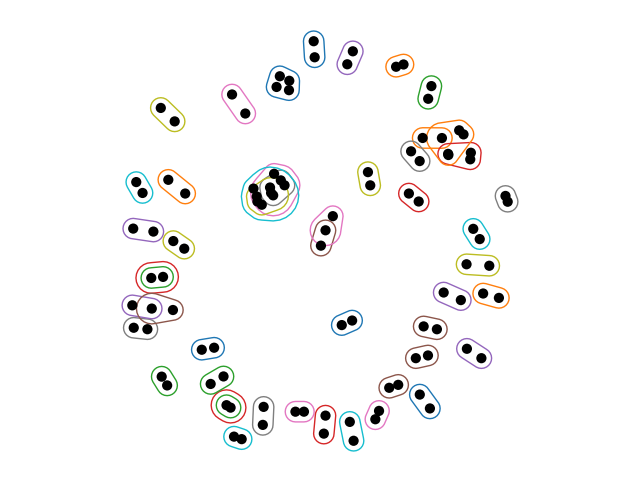

In [13]:
import matplotlib.pyplot as plt
import hypernetx as hnx 

# Get first 50 edge names
edge_names = list(G.edges)[:50]

# Create subgraph using only those edges
G_small = G.restrict_to_edges(edge_names)

plt.figure(figsize=(8, 6))
hnx.draw(G_small, fill_edges=False, with_node_labels=False, with_edge_labels=False)
plt.axis('off')
plt.show()

Found 292673 edges with names ≤ 20 characters
Sampled 30 edges:
  1. dispersed in
  2. are evident in
  3. is cooled in
  4. include
  5. have
  6. exhibited
  7. demonstrated
  8. enables
  9. contains
  10. used for


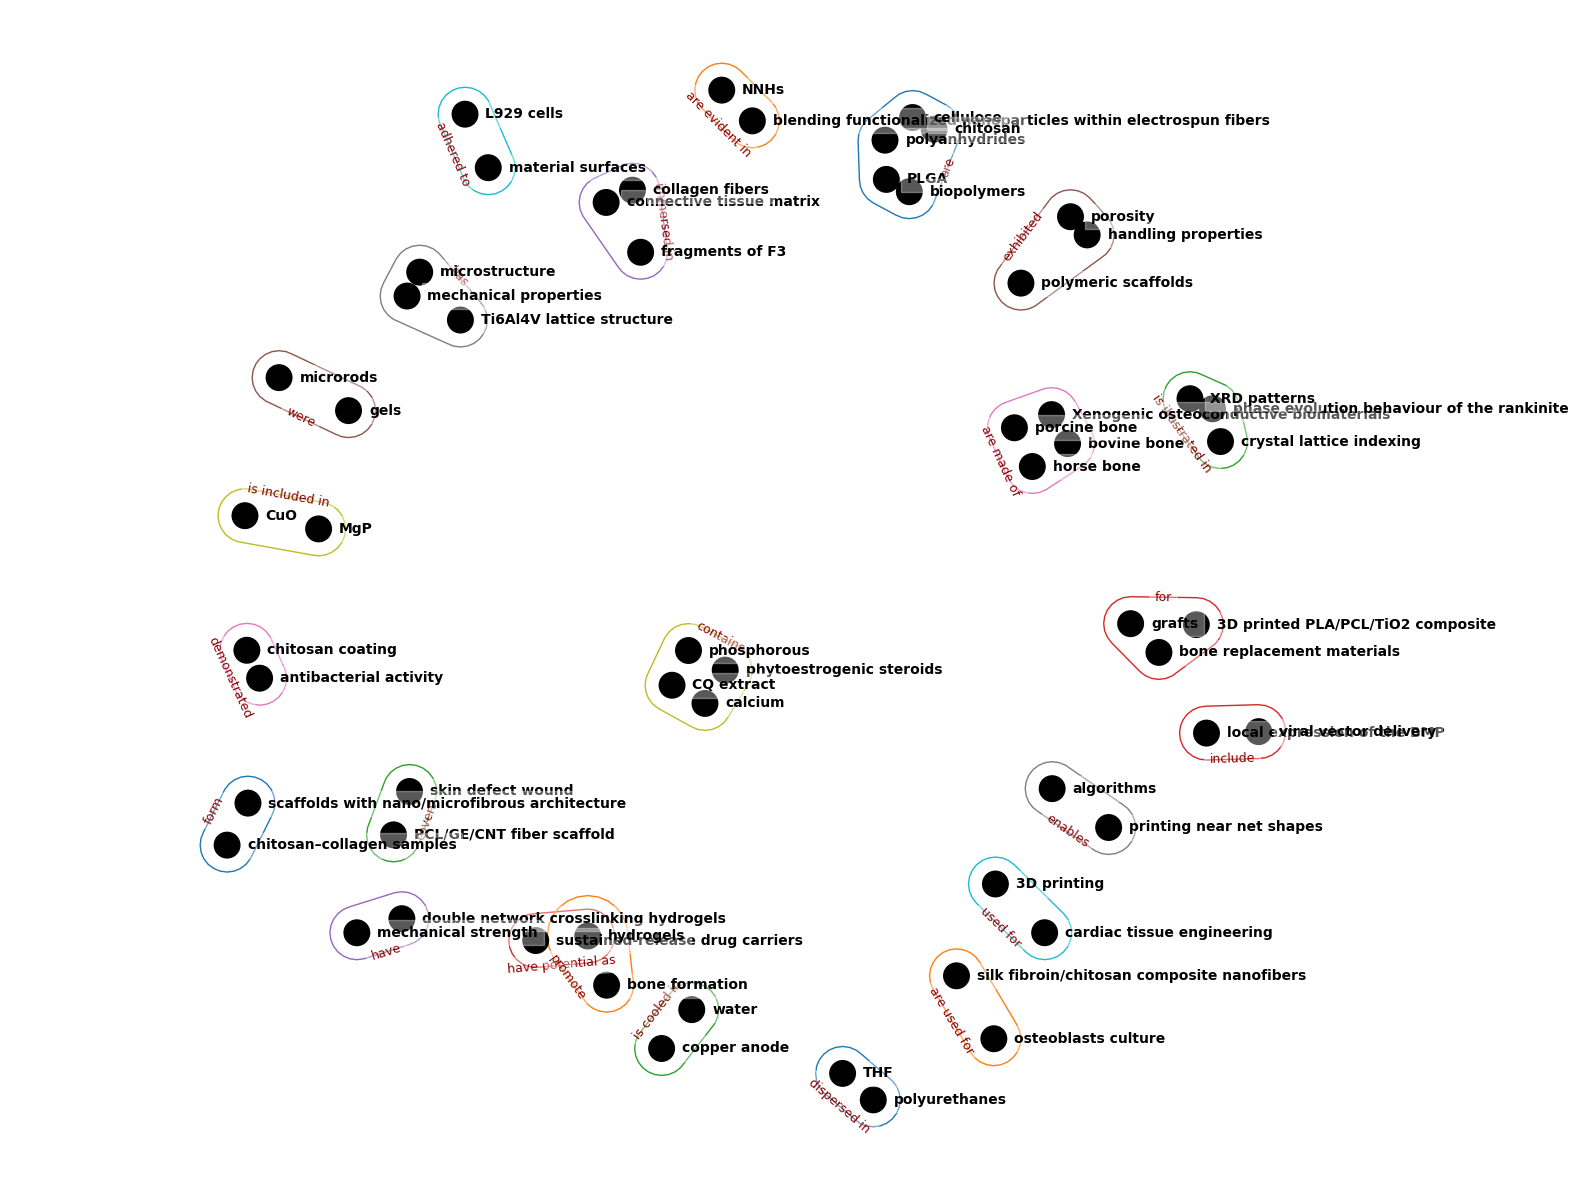

In [13]:
import matplotlib.pyplot as plt
import hypernetx as hnx 
import random

def clean_edge_name(edge_name):
    edge_str = str(edge_name)
    return edge_str.split('_chunk')[0] if '_chunk' in edge_str else edge_str

# Get edges with short cleaned names
edge_info = [(e, clean_edge_name(e)) for e in G.edges]
short_edges = [(orig, clean) for orig, clean in edge_info if len(clean) <= 20]

print(f"Found {len(short_edges)} edges with names ≤ 20 characters")

# Randomly sample 30 edges
random.seed(42)
sampled = random.sample(short_edges, min(30, len(short_edges)))

print(f"Sampled {len(sampled)} edges:")
for i, (_, clean) in enumerate(sampled[:10], 1):
    print(f"  {i}. {clean}")

# Create visualization
G_small = G.restrict_to_edges([orig for orig, _ in sampled])
cleaned_edges = {clean: list(G_small.edges[orig]) for orig, clean in sampled}
G_cleaned = hnx.Hypergraph(cleaned_edges)

plt.figure(figsize=(16, 12))
hnx.draw(
    G_cleaned, 
    fill_edges=False, 
    with_node_labels=True,
    with_edge_labels=True,
    node_labels_kwargs={'fontsize': 10, 'fontweight': 'bold', 'color': 'black'},
    edge_labels_kwargs={'fontsize': 9, 'color': 'darkred'}
)
plt.axis('off')
plt.tight_layout()
plt.show()

Found 292673 edges with short names
Sampled 5 edges

Results:
  Requested: 5 edges
  Final: 5 edges
  Edge names with duplicates: 0


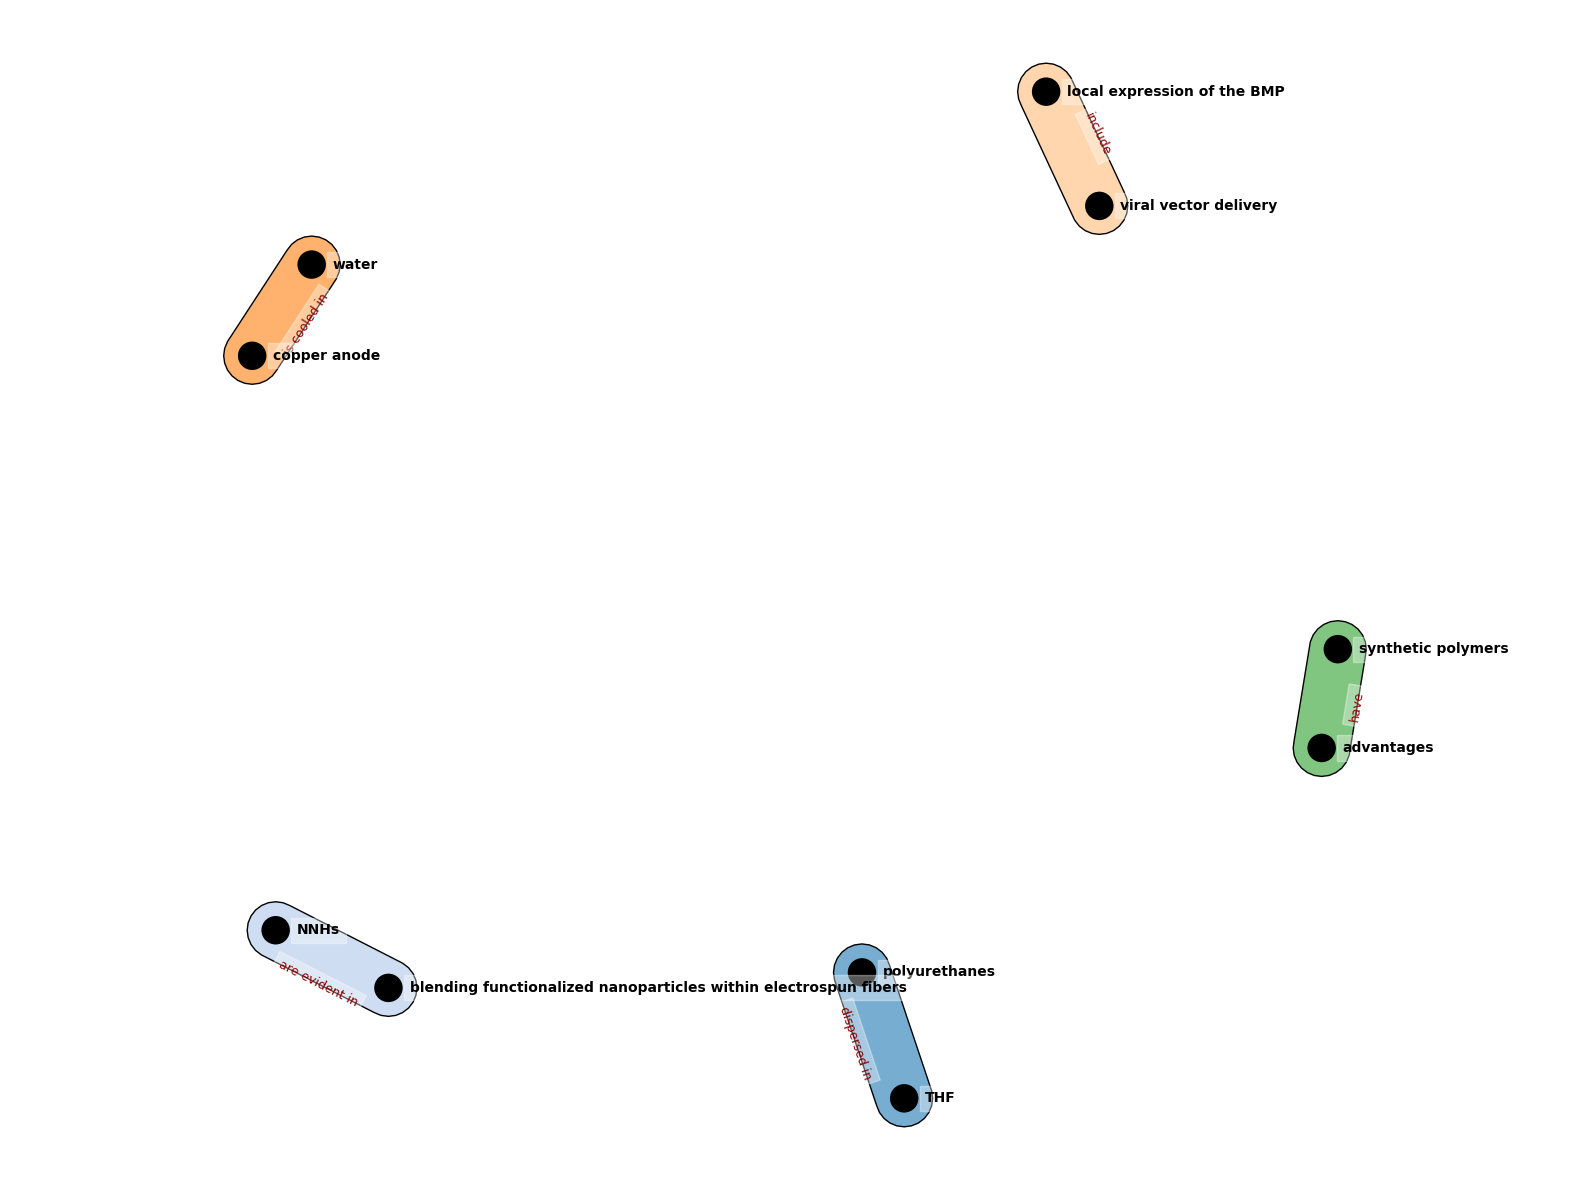

✔ Displayed 5 edges


In [14]:
import matplotlib.pyplot as plt
import hypernetx as hnx 
import numpy as np
import random

# ╔══════════════════════════════════════════════════════════╗
# ║  CHANGE THESE PARAMETERS TO CUSTOMIZE YOUR VISUALIZATION ║
# ╚══════════════════════════════════════════════════════════╝

NUM_EDGES = 5             # ← Change this number
MAX_NAME_LENGTH = 20        # ← Maximum edge name length
RANDOM_SEED = 42            # ← Change for different samples

# ══════════════════════════════════════════════════════════

def clean_edge_name(edge_name):
    edge_str = str(edge_name)
    return edge_str.split('_chunk')[0] if '_chunk' in edge_str else edge_str

# Sample edges
edge_info = [(e, clean_edge_name(e)) for e in G.edges]
short_edges = [(orig, clean) for orig, clean in edge_info if len(clean) <= MAX_NAME_LENGTH]

print(f"Found {len(short_edges)} edges with short names")

random.seed(RANDOM_SEED)
sampled = random.sample(short_edges, min(NUM_EDGES, len(short_edges)))

print(f"Sampled {len(sampled)} edges")

# Create hypergraph
G_small = G.restrict_to_edges([orig for orig, _ in sampled])

# ═══════════════════════════════════════════════════════════
# FIX: Add numeric suffix to duplicate edge names
# ═══════════════════════════════════════════════════════════
# Without this fix, edges like "PLA_chunk1" and "PLA_chunk2" 
# both become "PLA" and the second overwrites the first!
# ═══════════════════════════════════════════════════════════

cleaned_edges = {}
name_counts = {}

for orig, clean in sampled:
    # Track how many times we've seen this cleaned name
    if clean in name_counts:
        name_counts[clean] += 1
        # Add suffix to make it unique: "PLA_2", "PLA_3", etc.
        unique_name = f"{clean}_{name_counts[clean]}"
    else:
        name_counts[clean] = 1
        unique_name = clean
    
    cleaned_edges[unique_name] = list(G_small.edges[orig])

# Report results
duplicates = sum(1 for count in name_counts.values() if count > 1)
print(f"\nResults:")
print(f"  Requested: {NUM_EDGES} edges")
print(f"  Final: {len(cleaned_edges)} edges")
print(f"  Edge names with duplicates: {duplicates}")

G_cleaned = hnx.Hypergraph(cleaned_edges)

# Visualize with rainbow colors
plt.figure(figsize=(16, 12))

edge_list = list(G_cleaned.edges)
facecolors = {
    e: np.array(plt.cm.tab20(i % 20)) + np.array([0, 0, 0, -0.4])
    for i, e in enumerate(edge_list)
}

hnx.draw(
    G_cleaned,
    with_node_labels=True,
    with_edge_labels=True,
    edges_kwargs={
        'linewidths': 2,
        'edgecolors': 'black',
        'facecolors': facecolors
    },
    node_labels_kwargs={'fontsize': 10, 'fontweight': 'bold', 'color': 'black'},
    edge_labels_kwargs={'fontsize': 9, 'color': 'darkred'}
)

plt.axis('off')
plt.tight_layout()
plt.show()

print(f"✔ Displayed {len(edge_list)} edges")

# VIEW THE FULL INCIDENCE DATAFRAME FOR THE GRAPH 

In [15]:
# # 1) Using the incidences store directly:
# df = G.incidences.dataframe

# # 2) If you still hit Pandas’ truncation, bump the display limit:
# import pandas as pd
# pd.set_option("display.max_rows", None)
# display(df)
# pd.reset_option("display.max_rows")

# ANALYZE GRAPH CONTENT AND METRICS

Here we explicitly built the s-line graph:

Nodes = hyperedges of 
𝐺
G.

Edges = drawn between hyperedges if they share ≥ 
𝑠
s nodes.

Then you ran nx.connected_components, which finds connected components in that line graph.

👉 So those “components” are sets of hyperedges, too.
But you’re one step removed, because you made a graph-of-hyperedges first.

In [30]:
for s in range(1, 5):
    print(f"\nComputing components for s={s}...")
    
    components = list(G.s_connected_components(s=s, edges=False))
    
    print(f"# of connected components: {len(components)}")
    
    # Show size distribution
    sizes = sorted([len(c) for c in components], reverse=True)
    print(f"Largest component: {sizes[0]} edges")
    print(f"Top 10 sizes: {sizes[:10]}")


Computing components for s=1...
# of connected components: 3011
Largest component: 153987 edges
Top 10 sizes: [153987, 19, 14, 13, 12, 11, 10, 10, 8, 8]

Computing components for s=2...
# of connected components: 2618
Largest component: 27901 edges
Top 10 sizes: [27901, 19, 10, 10, 9, 9, 9, 9, 8, 8]

Computing components for s=3...
# of connected components: 1151
Largest component: 9082 edges
Top 10 sizes: [9082, 15, 13, 9, 7, 7, 6, 6, 6, 6]

Computing components for s=4...
# of connected components: 605
Largest component: 4503 edges
Top 10 sizes: [4503, 30, 11, 8, 7, 6, 6, 6, 6, 6]


# Compute Global Graph Metrics

In [29]:
from collections import Counter, defaultdict
from itertools import chain
from statistics import mean
from tabulate import tabulate  # make sure this is imported

def compute_hypergraph_metrics_fast(G, name="Hypergraph", overlap_thresholds=(1,2,3)):
    """
    Efficient metrics for large hypergraphs.
    - Avoids O(m^2) pairwise intersections.
    - Computes max intersection via per-edge neighbor counting.
    """
    # --- Basic sizes ---
    edge_list = list(G.edges)                 # hyperedge ids
    num_edges = len(edge_list)
    num_nodes = len(G.nodes)

    # Materialize edges as frozensets once (reused)
    edge_nodes = {e: frozenset(G.edges[e]) for e in edge_list}
    edge_sizes = [len(edge_nodes[e]) for e in edge_list]
    max_edge_size = max(edge_sizes) if edge_sizes else 0
    avg_edge_size = mean(edge_sizes) if edge_sizes else 0.0

    # --- Multi-edges (exact duplicates of node sets) ---
    # Hashable by frozenset, O(total edge size)
    edge_signatures = [edge_nodes[e] for e in edge_list]
    multi_edges = len(edge_signatures) - len(set(edge_signatures))

    # --- Inverted index: node -> list of incident edges ---
    node_to_edges = defaultdict(list)
    for e, nodes in edge_nodes.items():
        for u in nodes:
            node_to_edges[u].append(e)

    # --- Max edge intersection size & overlap counts ---
    # For each edge e, count overlaps with candidate edges that share at least one node.
    max_intersection = 0
    overlap_counts = {t: 0 for t in overlap_thresholds}  # number of edge pairs with >= t shared nodes

    # To avoid double counting pairs for overlap_counts, track pairs we’ve already finalized
    # We’ll accumulate per edge, but only count pairs when e_id < nbr_id
    for e in edge_list:
        # Count, for this e, how many shared nodes with each neighboring edge
        c = Counter()
        enodes = edge_nodes[e]
        for u in enodes:
            for nbr in node_to_edges[u]:
                if nbr != e:
                    c[nbr] += 1

        if c:
            local_max = max(c.values())
            if local_max > max_intersection:
                max_intersection = local_max

            # Thresholded pair counts (only once per unordered pair)
            for nbr, k in c.items():
                if e < nbr:  # canonicalize unordered pair
                    for t in overlap_thresholds:
                        if k >= t:
                            overlap_counts[t] += 1

    # --- Node degrees (hyperdegrees) ---
    # degree = number of hyperedges incident to the node
    node_degrees = [len(node_to_edges[u]) for u in G.nodes]
    avg_node_degree = mean(node_degrees) if node_degrees else 0.0
    max_node_degree = max(node_degrees) if node_degrees else 0

    # Package results
    out = {
        "Name": name,
        "# Nodes": num_nodes,
        "# Edges": num_edges,
        "Avg edge size": f"{avg_edge_size:.2f}",
        "Max edge size": max_edge_size,
        "Avg node degree": f"{avg_node_degree:.2f}",
        "Max node degree": max_node_degree,
        "# Multi-edges (exact dup sets)": multi_edges,
        "Max edge inter. size": max_intersection,
    }
    # Add overlap counts as separate columns
    for t in sorted(overlap_thresholds):
        out[f"# pairs overlap ≥{t}"] = overlap_counts[t]

    return out

# Example usage
results = [compute_hypergraph_metrics_fast(G, "MyGraph", overlap_thresholds=(1,2,3))]
print(tabulate(results, headers="keys", tablefmt="fancy_grid"))


╒═════════╤═══════════╤═══════════╤═════════════════╤═════════════════╤═══════════════════╤═══════════════════╤══════════════════════════════════╤════════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╕
│ Name    │   # Nodes │   # Edges │   Avg edge size │   Max edge size │   Avg node degree │   Max node degree │   # Multi-edges (exact dup sets) │   Max edge inter. size │   # pairs overlap ≥1 │   # pairs overlap ≥2 │   # pairs overlap ≥3 │
╞═════════╪═══════════╪═══════════╪═════════════════╪═════════════════╪═══════════════════╪═══════════════════╪══════════════════════════════════╪════════════════════════╪══════════════════════╪══════════════════════╪══════════════════════╡
│ MyGraph │    161172 │    320201 │            2.35 │              32 │              4.68 │             11157 │                            58997 │                     15 │            221063585 │              2787076 │               212355 │
╘═════════╧═══════════╧═══════════╧═

# Analyze Giant Component for its smoothness and dispersion

In [18]:
# from collections import defaultdict
# from tabulate import tabulate

# def analyze_giant_component_streaming(G, s=1):
#     """
#     Memory-efficient streaming analysis of giant component.
#     Processes edges one at a time without loading all into memory.
#     """
#     print(f"Finding giant component for s={s}...")
    
#     # Get the first (largest) component iterator
#     component_iter = G.s_connected_components(s=s, edges=True)
#     giant = next(component_iter)
    
#     print(f"Streaming analysis (processing edges one at a time)...")
    
#     # First pass: count edges, collect nodes, compute degrees
#     nodes_in_giant = set()
#     node_degree = defaultdict(int)
#     num_edges = 0
#     total_mentions = 0
    
#     # We need to iterate twice, so convert to list (unavoidable)
#     # But we'll do it in chunks to avoid memory spike
#     giant_edges = []
#     chunk_size = 10000
    
#     for i, e in enumerate(giant):
#         giant_edges.append(e)
        
#         # Process in chunks to monitor progress
#         if (i + 1) % chunk_size == 0:
#             print(f"  Loaded {i+1} edges...")
    
#     num_edges = len(giant_edges)
#     print(f"Total edges in giant component: {num_edges}")
    
#     # Now process in chunks to avoid memory issues
#     print("Computing node statistics...")
#     for i, e in enumerate(giant_edges):
#         if (i + 1) % chunk_size == 0:
#             print(f"  Processed {i+1}/{num_edges} edges...")
        
#         edge_nodes = G.edges[e]
#         nodes_in_giant.update(edge_nodes)
#         total_mentions += len(edge_nodes)
        
#         for node in edge_nodes:
#             node_degree[node] += 1
    
#     # Compute p-smoothness in chunks
#     print("Computing p-smoothness...")
#     smooth_sum = 0
#     for i, e in enumerate(giant_edges):
#         if (i + 1) % chunk_size == 0:
#             print(f"  Processed {i+1}/{num_edges} edges...")
        
#         edge_nodes = G.edges[e]
#         edge_sum = sum(node_degree[v] for v in edge_nodes)
#         smooth_sum += edge_sum / len(edge_nodes)
    
#     p_smoothness = smooth_sum / num_edges
    
#     # Compute other metrics
#     total_nodes = len(nodes_in_giant)
#     dispersion = total_nodes / total_mentions if total_mentions > 0 else 0
    
#     degree_values = list(node_degree.values())
#     avg_degree = sum(degree_values) / len(degree_values)
#     max_degree = max(degree_values)
    
#     # Node with max degree
#     hub_node = max(node_degree.items(), key=lambda x: x[1])
    
#     # Clear giant_edges to free memory
#     del giant_edges
    
#     metrics = {
#         "Metric": ["Num Edges", "Num Nodes", "p-smoothness", "dispersion", 
#                    "Avg Node Degree", "Max Node Degree", "Hub Node"],
#         "Value": [
#             num_edges,
#             total_nodes,
#             round(p_smoothness, 4),
#             round(dispersion, 4),
#             round(avg_degree, 2),
#             max_degree,
#             f"{str(hub_node[0])[:50]}... (degree={hub_node[1]})" if len(str(hub_node[0])) > 50 else f"{hub_node[0]} (degree={hub_node[1]})"
#         ]
#     }
    
#     return metrics

# # Analyze s=2 first (smaller, safer)
# print("=" * 60)
# print("GIANT COMPONENT ANALYSIS (s=2)")
# print("=" * 60)
# metrics_s2 = analyze_giant_component_streaming(G, s=2)
# print(tabulate(metrics_s2, headers="keys", tablefmt="fancy_grid"))

# # Only try s=1 if s=2 worked
# print("\n" + "=" * 60)
# print("GIANT COMPONENT ANALYSIS (s=1)")
# print("=" * 60)
# print("WARNING: This may take several minutes and use significant memory...")
# metrics_s1 = analyze_giant_component_streaming(G, s=1)
# print(tabulate(metrics_s1, headers="keys", tablefmt="fancy_grid"))


In [19]:
# Degree Distribution Analysis 

STEP 1/5: Computing node degrees...
  Processed 50000/320201 edges (15.6%)
  Processed 100000/320201 edges (31.2%)
  Processed 150000/320201 edges (46.8%)
  Processed 200000/320201 edges (62.5%)
  Processed 250000/320201 edges (78.1%)
  Processed 300000/320201 edges (93.7%)
✔ Completed degree counting for 161172 nodes.

STEP 2/5: BASIC STATISTICS
Total nodes: 161172
Avg degree: 4.68
Median degree: 1.00
Std deviation: 52.57
Max degree: 11157
Nodes with degree 1: 95498 (59.3%)

Top 10 hub nodes:
  1. scaffolds: 11157
  2. biocompatibility: 5329
  3. chitosan: 5211
  4. bone tissue engineering: 4148
  5. hydrogels: 4076
  6. tissue engineering: 3713
  7. mechanical properties: 3521
  8. PCL: 3369
  9. cells: 3360
  10. bone regeneration: 3317

STEP 3/5: Fitting power-law (log–log regression)...
Power-law exponent γ = 1.232
R² = 0.755

STEP 4/5: Computing inequality metrics...
Gini coefficient: 0.718
Heterogeneity: 11.243
Top 1% control 43.2% of all degree mass

STEP 5/5: Computing CCDF...

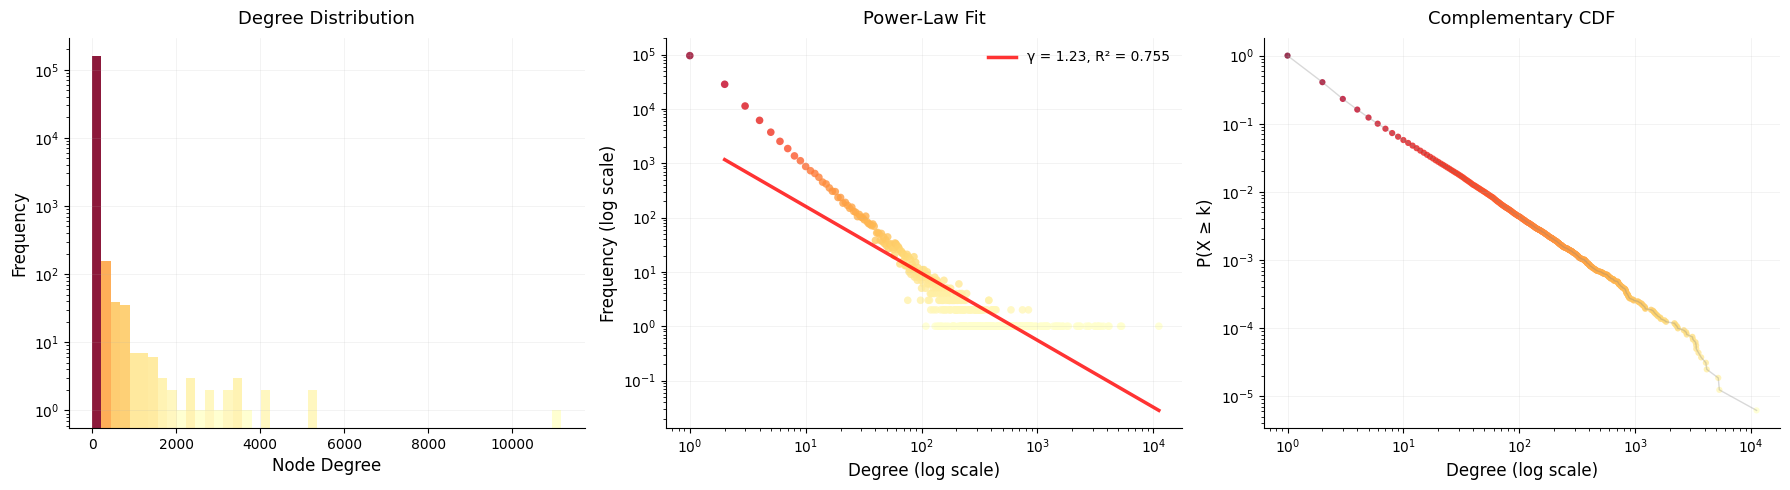


✔ ANALYSIS COMPLETE


In [20]:
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def analyze_degree_distribution_enhanced(G):
    """Comprehensive degree distribution analysis with power-law fitting + progress tracking"""
    
    # ================================
    # PART 1 — Compute node degrees
    # ================================
    print("="*60)
    print("STEP 1/5: Computing node degrees...")
    print("="*60)

    node_degrees = defaultdict(int)
    total_edges = len(G.edges)

    for idx, e in enumerate(G.edges):
        if (idx + 1) % 50000 == 0:
            print(f"  Processed {idx+1}/{total_edges} edges ({100*(idx+1)/total_edges:.1f}%)")
        for node in G.edges[e]:
            node_degrees[node] += 1

    print(f"✔ Completed degree counting for {len(node_degrees)} nodes.")
    
    degrees = np.array(list(node_degrees.values()))
    degree_counts = Counter(degrees)
    
    # ================================
    # PART 2 — Basic stats
    # ================================
    print("\n" + "="*60)
    print("STEP 2/5: BASIC STATISTICS")
    print("="*60)
    print(f"Total nodes: {len(degrees)}")
    print(f"Avg degree: {np.mean(degrees):.2f}")
    print(f"Median degree: {np.median(degrees):.2f}")
    print(f"Std deviation: {np.std(degrees):.2f}")
    print(f"Max degree: {max(degrees)}")
    print(f"Nodes with degree 1: {degree_counts[1]} ({100*degree_counts[1]/len(degrees):.1f}%)")
    
    print("\nTop 10 hub nodes:")
    top_nodes = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
    for i, (node, deg) in enumerate(top_nodes, 1):
        print(f"  {i}. {str(node)[:50]}: {deg}")

    # ================================
    # PART 3 — Power-law Analysis
    # ================================
    print("\n" + "="*60)
    print("STEP 3/5: Fitting power-law (log–log regression)...")
    print("="*60)

    # Prepare data (exclude low degrees)
    unique_degrees = np.array(sorted(degree_counts.keys()))
    frequencies = np.array([degree_counts[d] for d in unique_degrees])

    min_degree = 2
    mask = unique_degrees >= min_degree
    x_fit = unique_degrees[mask]
    y_fit = frequencies[mask]

    try:
        log_x = np.log(x_fit)
        log_y = np.log(y_fit)

        slope, intercept, r_value, p_value, std_err = stats.linregress(log_x, log_y)
        gamma = -slope

        print(f"Power-law exponent γ = {gamma:.3f}")
        print(f"R² = {r_value**2:.3f}")

    except Exception as e:
        print(f"Power-law fitting failed: {e}")
        gamma = None
        intercept = None
        r_value = None

    # ================================
    # PART 4 — Inequality Metrics
    # ================================
    print("\n" + "="*60)
    print("STEP 4/5: Computing inequality metrics...")
    print("="*60)

    sorted_degrees = np.sort(degrees)
    n = len(sorted_degrees)
    gini = (2 * np.sum((np.arange(1, n+1)) * sorted_degrees)) / (n * np.sum(sorted_degrees)) - (n + 1) / n

    print(f"Gini coefficient: {gini:.3f}")
    heterogeneity = np.std(degrees) / np.mean(degrees)
    print(f"Heterogeneity: {heterogeneity:.3f}")

    top_1_percent = max(1, int(0.01 * len(degrees)))
    top_1_share = np.sum(sorted_degrees[-top_1_percent:]) / np.sum(degrees)
    print(f"Top 1% control {100*top_1_share:.1f}% of all degree mass")

    # ================================
    # PART 5 — CCDF (progress tracked)
    # ================================
    print("\n" + "="*60)
    print("STEP 5/5: Computing CCDF...")
    print("="*60)

    sorted_unique = np.array(sorted(degree_counts.keys()))
    ccdf = []
    total_unique = len(sorted_unique)

    for idx, k in enumerate(sorted_unique):
        if (idx + 1) % 50 == 0:
            print(f"  CCDF progress: {idx+1}/{total_unique} values ({100*(idx+1)/total_unique:.1f}%)")
        ccdf.append(sum(degree_counts[d] for d in sorted_unique if d >= k))

    ccdf = np.array(ccdf) / len(degrees)

    print("✔ CCDF computed.")

    # ================================
    # PART 6 — Plotting with YlOrRd aesthetic
    # ================================
    print("\n" + "="*60)
    print("STEP 6/6: Generating visualizations...")
    print("="*60)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), facecolor='white')
    
    cmap = plt.cm.YlOrRd

    # ============ Subplot 1 — Histogram ============
    ax1 = axes[0]
    
    # Create histogram data
    counts, bins = np.histogram(degrees, bins=50)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Color by log frequency
    norm = plt.Normalize(vmin=np.log10(counts[counts > 0].min()), 
                         vmax=np.log10(counts.max()))
    
    for i, (count, center) in enumerate(zip(counts, bin_centers)):
        if count > 0:
            color = cmap(norm(np.log10(count)))
            ax1.bar(center, count, width=bins[1]-bins[0], 
                   color=color, edgecolor='none', alpha=0.9)
    
    ax1.set_xlabel('Node Degree', fontsize=12, fontweight='normal')
    ax1.set_ylabel('Frequency', fontsize=12, fontweight='normal')
    ax1.set_yscale('log')
    ax1.set_title('Degree Distribution', fontsize=13, pad=10)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)

    # ============ Subplot 2 — Log-Log power-law ============
    ax2 = axes[1]
    
    # Color points by log frequency
    colors = [cmap(norm(np.log10(f))) for f in frequencies]
    ax2.scatter(unique_degrees, frequencies, c=colors, s=30, alpha=0.8, edgecolors='none')
    
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Degree (log scale)', fontsize=12, fontweight='normal')
    ax2.set_ylabel('Frequency (log scale)', fontsize=12, fontweight='normal')
    
    # Add power-law fit line
    if gamma is not None:
        x_line = np.logspace(np.log10(min(x_fit)), np.log10(max(x_fit)), 100)
        y_line = np.exp(intercept) * x_line**(-gamma)
        ax2.plot(x_line, y_line, 'r-', linewidth=2.5, alpha=0.8, 
                label=f'γ = {gamma:.2f}, R² = {r_value**2:.3f}')
        ax2.legend(frameon=False, fontsize=10)
    
    ax2.set_title('Power-Law Fit', fontsize=13, pad=10)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)

    # ============ Subplot 3 — CCDF ============
    ax3 = axes[2]
    
    # Color CCDF points by their value
    ccdf_norm = plt.Normalize(vmin=np.log10(ccdf[ccdf > 0].min()), 
                               vmax=np.log10(ccdf.max()))
    ccdf_colors = [cmap(ccdf_norm(np.log10(c))) if c > 0 else cmap(0) for c in ccdf]
    
    ax3.scatter(sorted_unique, ccdf, c=ccdf_colors, s=20, alpha=0.8, edgecolors='none')
    ax3.plot(sorted_unique, ccdf, '-', color='gray', alpha=0.3, linewidth=1)
    
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_xlabel('Degree (log scale)', fontsize=12, fontweight='normal')
    ax3.set_ylabel('P(X ≥ k)', fontsize=12, fontweight='normal')
    ax3.set_title('Complementary CDF', fontsize=13, pad=10)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)

    plt.tight_layout()
    plt.show()

    print("\n✔ ANALYSIS COMPLETE")

    return {
        'node_degrees': node_degrees,
        'degree_counts': degree_counts,
        'power_law_exponent': gamma,
        'gini_coefficient': gini,
        'heterogeneity': heterogeneity,
        'ccdf': (sorted_unique, ccdf)
    }

# Usage:
# results = analyze_degree_distribution_enhanced(G)

# Run the enhanced analysis
results = analyze_degree_distribution_enhanced(G)

In [21]:
# Edge Size Distribution Analysis

In [22]:
def analyze_edge_sizes(G):
    """Distribution of hyperedge sizes"""
    edge_sizes = [len(G.edges[e]) for e in G.edges]
    size_counts = Counter(edge_sizes)
    
    print(f"Total edges: {len(edge_sizes)}")
    print(f"Avg edge size: {sum(edge_sizes)/len(edge_sizes):.2f}")
    print(f"Max edge size: {max(edge_sizes)}")
    print(f"\nEdge size distribution:")
    for size in sorted(size_counts.keys())[:15]:  # First 15
        print(f"  Size {size}: {size_counts[size]} edges")
    
    # Find largest edges
    print(f"\nTop 10 largest edges:")
    edges_with_sizes = [(e, len(G.edges[e])) for e in list(G.edges)[:10000]]  # Sample
    top_edges = sorted(edges_with_sizes, key=lambda x: x[1], reverse=True)[:10]
    for edge_id, size in top_edges:
        print(f"  Edge {edge_id}: {size} nodes")
    
    return size_counts

analyze_edge_sizes(G)

Total edges: 320201
Avg edge size: 2.35
Max edge size: 32

Edge size distribution:
  Size 1: 98 edges
  Size 2: 246468 edges
  Size 3: 48559 edges
  Size 4: 16967 edges
  Size 5: 4817 edges
  Size 6: 1871 edges
  Size 7: 701 edges
  Size 8: 342 edges
  Size 9: 135 edges
  Size 10: 92 edges
  Size 11: 53 edges
  Size 12: 29 edges
  Size 13: 14 edges
  Size 14: 35 edges
  Size 15: 4 edges

Top 10 largest edges:
  Edge affect_chunkdc82efdb1f4b524092916eab8535fd04_0: 14 nodes
  Edge affected by_chunk76a32179d35e5fe0eabbf7a58f3458cc_49: 10 nodes
  Edge affect_chunk27accf6afa2bb1236376f59835146884_10: 9 nodes
  Edge affects_chunkcd7fbdafee569bc25bd2ed83e78c41f3_40: 9 nodes
  Edge Mechanical properties_chunk579b2ea99de8384a5bfaebd8b5fdc387_25: 8 nodes
  Edge Mechanical properties_chunk579b2ea99de8384a5bfaebd8b5fdc387_31: 8 nodes
  Edge Structure_chunk579b2ea99de8384a5bfaebd8b5fdc387_24: 8 nodes
  Edge acknowledge_chunka29f98f37db32e441f4d6c280bf5302e_0: 8 nodes
  Edge acquired from_chunk0d32c

Counter({2: 246468,
         3: 48559,
         4: 16967,
         5: 4817,
         6: 1871,
         7: 701,
         8: 342,
         9: 135,
         1: 98,
         10: 92,
         11: 53,
         14: 35,
         12: 29,
         13: 14,
         17: 6,
         16: 5,
         15: 4,
         22: 2,
         32: 1,
         23: 1,
         18: 1})

In [23]:
# Node-Edge Incidence Pattern 

In [24]:
def analyze_incidence_patterns(G, sample_nodes=1000):
    """How nodes are distributed across edges"""
    from random import sample
    
    node_to_edges = defaultdict(set)
    
    for e in G.edges:
        for node in G.edges[e]:
            node_to_edges[node].add(e)
    
    # Sample nodes for detailed analysis
    all_nodes = list(G.nodes)
    sampled = sample(all_nodes, min(sample_nodes, len(all_nodes)))
    
    # Check how many nodes appear in same edges
    co_occurrence_counts = []
    
    for node in sampled:
        node_edges = node_to_edges[node]
        # Count other nodes in these edges
        co_occurring = set()
        for e in node_edges:
            co_occurring.update(G.edges[e])
        co_occurrence_counts.append(len(co_occurring) - 1)  # Exclude self
    
    avg_co = sum(co_occurrence_counts)/len(co_occurrence_counts)
    max_co = max(co_occurrence_counts)
    
    print(f"Average co-occurring nodes per node: {avg_co:.2f}")
    print(f"Max co-occurring nodes: {max_co}")
    
    # Return just the statistics, not the huge defaultdict
    return {"avg_co_occurrence": avg_co, "max_co_occurrence": max_co}

# # Call without printing return value, or assign to variable
# result = analyze_incidence_patterns(G)
# # # or just:
analyze_incidence_patterns(G)

Average co-occurring nodes per node: 6.64
Max co-occurring nodes: 2153


{'avg_co_occurrence': 6.638, 'max_co_occurrence': 2153}

In [25]:
# Component Size Distribution

In [26]:
def analyze_component_sizes(G, s=1):
    """Quick component size histogram"""
    components = G.s_connected_components(s=s, edges=False)
    
    sizes = []
    for i, comp in enumerate(components):
        size = len(list(comp))
        sizes.append(size)
        
        if i % 100 == 0 and i > 0:
            print(f"Processed {i} components...")
    
    size_counts = Counter(sizes)
    
    print(f"\nTotal components: {len(sizes)}")
    print(f"Giant component: {max(sizes)} edges")
    print(f"Components of size 2: {size_counts[2]}")
    print(f"Components of size 3: {size_counts[3]}")
    
    # Distribution
    print("\nSize distribution:")
    for size in sorted(size_counts.keys())[:20]:
        print(f"  Size {size}: {size_counts[size]} components")
    
    return sizes

sizes_s1 = analyze_component_sizes(G, s=1)

Processed 100 components...
Processed 200 components...
Processed 300 components...
Processed 400 components...
Processed 500 components...
Processed 600 components...
Processed 700 components...
Processed 800 components...
Processed 900 components...
Processed 1000 components...
Processed 1100 components...
Processed 1200 components...
Processed 1300 components...
Processed 1400 components...
Processed 1500 components...
Processed 1600 components...
Processed 1700 components...
Processed 1800 components...
Processed 1900 components...
Processed 2000 components...
Processed 2100 components...
Processed 2200 components...
Processed 2300 components...
Processed 2400 components...
Processed 2500 components...
Processed 2600 components...
Processed 2700 components...
Processed 2800 components...
Processed 2900 components...
Processed 3000 components...

Total components: 3011
Giant component: 153987 edges
Components of size 2: 2296
Components of size 3: 476

Size distribution:
  Size 2: 22

In [27]:
# Subgraph Sampling for Detailed Analysis (fast)

Subgraph: 500 edges, 1002 nodes


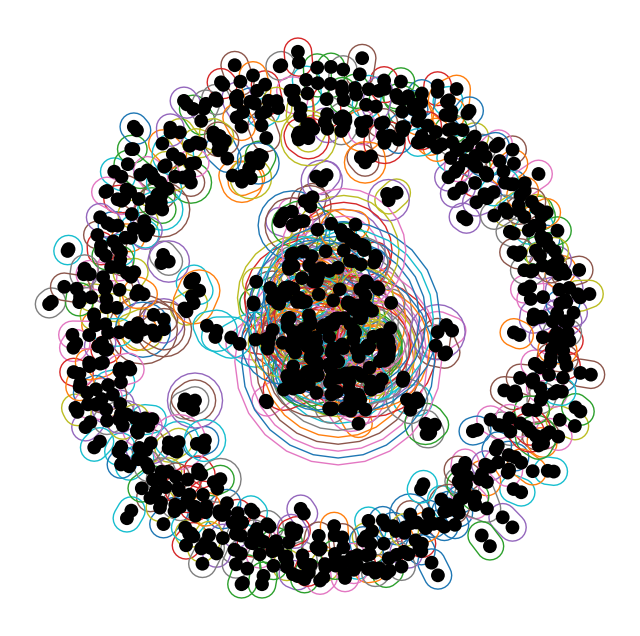

In [28]:
def sample_and_analyze_subgraph(G, num_edges=5000):
    """Extract random subgraph for detailed analysis"""
    import random
    
    edge_sample = random.sample(list(G.edges), min(num_edges, len(G.edges)))
    
    # Convert to simple lists to avoid deepcopy issues
    edge_dict = {e: list(G.edges[e]) for e in edge_sample}
    
    G_sub = hnx.Hypergraph(edge_dict)
    
    print(f"Subgraph: {len(G_sub.edges)} edges, {len(G_sub.nodes)} nodes")
    
    return G_sub

G_small = sample_and_analyze_subgraph(G, num_edges=500)
hnx.draw(G_small, with_node_labels=False, with_edge_labels=False)
plt.show()

In [29]:
# Connectivity Progression (medium speed)

In [30]:
from tabulate import tabulate
def analyze_connectivity_progression(G, max_s=5):
    """How connectivity changes with s"""
    results = []
    
    for s in range(1, max_s + 1):
        print(f"Computing s={s}...")
        
        components = list(G.s_connected_components(s=s, edges=False))
        sizes = [len(list(c)) for c in components]
        
        results.append({
            "s": s,
            "# components": len(sizes),
            "Giant size": max(sizes),
            "Avg component size": sum(sizes) / len(sizes)
        })
    
    print(tabulate(results, headers="keys", tablefmt="fancy_grid"))
    return results

analyze_connectivity_progression(G, max_s=3)

Computing s=1...
Computing s=2...
Computing s=3...
╒═════╤════════════════╤══════════════╤══════════════════════╕
│   s │   # components │   Giant size │   Avg component size │
╞═════╪════════════════╪══════════════╪══════════════════════╡
│   1 │           3011 │       153987 │              53.5251 │
├─────┼────────────────┼──────────────┼──────────────────────┤
│   2 │           2618 │        27901 │              13.0053 │
├─────┼────────────────┼──────────────┼──────────────────────┤
│   3 │           1151 │         9082 │              10.225  │
╘═════╧════════════════╧══════════════╧══════════════════════╛


[{'s': 1,
  '# components': 3011,
  'Giant size': 153987,
  'Avg component size': 53.52507472600465},
 {'s': 2,
  '# components': 2618,
  'Giant size': 27901,
  'Avg component size': 13.005347593582888},
 {'s': 3,
  '# components': 1151,
  'Giant size': 9082,
  'Avg component size': 10.225021720243268}]

In [31]:
# Hub Node Analysis

In [32]:
def find_hub_nodes(G, top_k=20):
    """Identify most connected nodes"""
    node_degrees = defaultdict(int)
    
    for e in G.edges:
        for node in G.edges[e]:
            node_degrees[node] += 1
    
    top_hubs = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)[:top_k]
    
    print(f"Top {top_k} hub nodes:")
    for i, (node, degree) in enumerate(top_hubs, 1):
        print(f"{i}. {str(node)[:70]}: degree {degree}")
    
    return top_hubs

find_hub_nodes(G, top_k=20)

Top 20 hub nodes:
1. scaffolds: degree 11157
2. biocompatibility: degree 5329
3. chitosan: degree 5211
4. bone tissue engineering: degree 4148
5. hydrogels: degree 4076
6. tissue engineering: degree 3713
7. mechanical properties: degree 3521
8. PCL: degree 3369
9. cells: degree 3360
10. bone regeneration: degree 3317
11. porosity: degree 3154
12. hydroxyapatite: degree 3117
13. collagen: degree 2788
14. samples: degree 2756
15. biodegradability: degree 2632
16. HA: degree 2338
17. gelatin: degree 2303
18. composites: degree 2234
19. proliferation: degree 2182
20. alginate: degree 1847


[('scaffolds', 11157),
 ('biocompatibility', 5329),
 ('chitosan', 5211),
 ('bone tissue engineering', 4148),
 ('hydrogels', 4076),
 ('tissue engineering', 3713),
 ('mechanical properties', 3521),
 ('PCL', 3369),
 ('cells', 3360),
 ('bone regeneration', 3317),
 ('porosity', 3154),
 ('hydroxyapatite', 3117),
 ('collagen', 2788),
 ('samples', 2756),
 ('biodegradability', 2632),
 ('HA', 2338),
 ('gelatin', 2303),
 ('composites', 2234),
 ('proliferation', 2182),
 ('alginate', 1847)]

In [33]:
# k-Core Decomposition

In [34]:
def compute_k_core_decomposition(G, max_k=10):
    """
    Find k-cores: maximal subgraphs where every node has degree >= k
    Reveals hierarchical organization and identifies resilient core
    """
    from collections import defaultdict
    
    # Build node degrees
    node_degrees = defaultdict(int)
    node_to_edges = defaultdict(set)
    
    for e in G.edges:
        for node in G.edges[e]:
            node_degrees[node] += 1
            node_to_edges[node].add(e)
    
    # Core decomposition
    core_numbers = {}
    active_nodes = set(G.nodes)
    
    for k in range(1, max_k + 1):
        print(f"Computing {k}-core...")
        
        # Remove nodes with degree < k iteratively
        changed = True
        while changed:
            changed = False
            to_remove = []
            
            for node in active_nodes:
                if node_degrees[node] < k:
                    to_remove.append(node)
                    changed = True
            
            for node in to_remove:
                active_nodes.remove(node)
                core_numbers[node] = k - 1
                
                # Update neighbors' degrees
                for e in node_to_edges[node]:
                    for neighbor in G.edges[e]:
                        if neighbor in active_nodes:
                            node_degrees[neighbor] -= 1
        
        print(f"  {k}-core has {len(active_nodes)} nodes")
        
        if len(active_nodes) == 0:
            break
    
    # Remaining nodes are in highest core
    for node in active_nodes:
        core_numbers[node] = k
    
    # Analysis
    from collections import Counter
    core_dist = Counter(core_numbers.values())
    
    results = []
    for k_val in sorted(core_dist.keys()):
        results.append({
            "k-core": k_val,
            "# nodes": core_dist[k_val],
            "% of total": f"{100 * core_dist[k_val] / len(G.nodes):.2f}%"
        })
    
    print("\nCore decomposition:")
    print(tabulate(results, headers="keys", tablefmt="fancy_grid"))
    
    return core_numbers

core_nums = compute_k_core_decomposition(G, max_k=10)

Computing 1-core...
  1-core has 161172 nodes
Computing 2-core...
  2-core has 48953 nodes
Computing 3-core...
  3-core has 21296 nodes
Computing 4-core...
  4-core has 11726 nodes
Computing 5-core...
  5-core has 6466 nodes
Computing 6-core...
  6-core has 126 nodes
Computing 7-core...
  7-core has 81 nodes
Computing 8-core...
  8-core has 52 nodes
Computing 9-core...
  9-core has 31 nodes
Computing 10-core...
  10-core has 24 nodes

Core decomposition:
╒══════════╤═══════════╤══════════════╕
│   k-core │   # nodes │ % of total   │
╞══════════╪═══════════╪══════════════╡
│        1 │    112219 │ 69.63%       │
├──────────┼───────────┼──────────────┤
│        2 │     27657 │ 17.16%       │
├──────────┼───────────┼──────────────┤
│        3 │      9570 │ 5.94%        │
├──────────┼───────────┼──────────────┤
│        4 │      5260 │ 3.26%        │
├──────────┼───────────┼──────────────┤
│        5 │      6340 │ 3.93%        │
├──────────┼───────────┼──────────────┤
│        6 │        4

In [39]:
# Rich Club

In [40]:
from tabulate import tabulate 
def compute_rich_club(G, degree_thresholds=[10, 20, 50, 100]):
    """
    Rich club: do high-degree nodes form a densely connected subgraph?
    """
    from collections import defaultdict
    
    # Node degrees
    node_degrees = defaultdict(int)
    node_to_edges = defaultdict(set)
    
    for e in G.edges:
        for node in G.edges[e]:
            node_degrees[node] += 1
            node_to_edges[node].add(e)
    
    results = []
    
    for k in degree_thresholds:
        # Nodes with degree >= k
        rich_nodes = {n for n, d in node_degrees.items() if d >= k}
        
        if len(rich_nodes) < 2:
            continue
        
        print(f"Computing rich club for degree >= {k} ({len(rich_nodes)} nodes)...")
        
        # Edges among rich nodes
        edges_among_rich = 0
        total_edges_checked = 0
        
        for e in G.edges:
            total_edges_checked += 1
            if total_edges_checked % 50000 == 0:
                print(f"  Checked {total_edges_checked} edges...")
            
            e_nodes = set(G.edges[e])
            
            # Does this edge connect only rich nodes?
            if e_nodes.issubset(rich_nodes) and len(e_nodes) >= 2:
                edges_among_rich += 1
        
        # Rich club coefficient
        # Actual edges / possible edges among rich nodes
        possible_edges = len(rich_nodes) * (len(rich_nodes) - 1) / 2
        
        phi = edges_among_rich / possible_edges if possible_edges > 0 else 0
        
        results.append({
            "Degree threshold": k,
            "# rich nodes": len(rich_nodes),
            "Edges among rich": edges_among_rich,
            "Rich club coeff": f"{phi:.6f}"
        })
    
    print("\nRich club analysis:")
    print(tabulate(results, headers="keys", tablefmt="fancy_grid"))
    
    return results

rich_club = compute_rich_club(G, degree_thresholds=[10, 20, 50, 100])

Computing rich club for degree >= 10 (9295 nodes)...
  Checked 50000 edges...
  Checked 100000 edges...
  Checked 150000 edges...
  Checked 200000 edges...
  Checked 250000 edges...
  Checked 300000 edges...
Computing rich club for degree >= 20 (4445 nodes)...
  Checked 50000 edges...
  Checked 100000 edges...
  Checked 150000 edges...
  Checked 200000 edges...
  Checked 250000 edges...
  Checked 300000 edges...
Computing rich club for degree >= 50 (1611 nodes)...
  Checked 50000 edges...
  Checked 100000 edges...
  Checked 150000 edges...
  Checked 200000 edges...
  Checked 250000 edges...
  Checked 300000 edges...
Computing rich club for degree >= 100 (701 nodes)...
  Checked 50000 edges...
  Checked 100000 edges...
  Checked 150000 edges...
  Checked 200000 edges...
  Checked 250000 edges...
  Checked 300000 edges...

Rich club analysis:
╒════════════════════╤════════════════╤════════════════════╤═══════════════════╕
│   Degree threshold │   # rich nodes │   Edges among rich │   Ric

In [41]:
#Huge ego network analysis 

In [22]:
from tabulate import tabulate 

def analyze_hub_neighborhoods(G, top_k=20):
    """
    Analyze local structure around top hub nodes.
    Shows how hubs connect and what concepts cluster together.
    """
    from collections import defaultdict
    
    # Get node degrees
    node_degrees = defaultdict(int)
    node_to_edges = defaultdict(set)
    
    for e in G.edges:
        for node in G.edges[e]:
            node_degrees[node] += 1
            node_to_edges[node].add(e)
    
    # Top hubs
    top_hubs = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)[:top_k]
    
    results = []
    
    print(f"Analyzing neighborhoods of top {top_k} hubs...\n")
    
    for hub_node, hub_degree in top_hubs:
        # Get all nodes that co-occur with this hub
        neighbors = set()
        hub_edges = node_to_edges[hub_node]
        
        for e in hub_edges:
            neighbors.update(G.edges[e])
        neighbors.discard(hub_node)
        
        # Count edges among neighbors (clustering indicator)
        edges_among_neighbors = 0
        for e in G.edges:
            e_nodes = set(G.edges[e])
            if hub_node not in e_nodes and e_nodes.issubset(neighbors):
                edges_among_neighbors += 1
        
        # Get top co-occurring neighbors
        neighbor_counts = defaultdict(int)
        for e in hub_edges:
            for neighbor in G.edges[e]:
                if neighbor != hub_node:
                    neighbor_counts[neighbor] += 1
        
        top_cooccur = sorted(neighbor_counts.items(), key=lambda x: x[1], reverse=True)[:5]
        
        results.append({
            "Hub": str(hub_node)[:40],
            "Degree": hub_degree,
            "Unique Neighbors": len(neighbors),
            "Neighbor Density": len(neighbors) / hub_degree,  # avg nodes per edge
            "Neighbor Edges": edges_among_neighbors,
            "Top Co-occurring": ", ".join([f"{str(n)[:20]}({c})" for n, c in top_cooccur[:3]])
        })
    
    print(tabulate(results, headers="keys", tablefmt="fancy_grid"))
    
    return results

hub_analysis = analyze_hub_neighborhoods(G, top_k=20)

Analyzing neighborhoods of top 20 hubs...

╒═════════════════════════╤══════════╤════════════════════╤════════════════════╤══════════════════╤════════════════════════════════════════════════════════════════╕
│ Hub                     │   Degree │   Unique Neighbors │   Neighbor Density │   Neighbor Edges │ Top Co-occurring                                               │
╞═════════════════════════╪══════════╪════════════════════╪════════════════════╪══════════════════╪════════════════════════════════════════════════════════════════╡
│ scaffolds               │    11157 │               5440 │           0.487586 │            36410 │ porosity(967), biodegradability(624), cells(288)               │
├─────────────────────────┼──────────┼────────────────────┼────────────────────┼──────────────────┼────────────────────────────────────────────────────────────────┤
│ biocompatibility        │     5329 │               4103 │           0.769938 │            34705 │ biodegradability(799), scaffolds

In [23]:
#TSNE plot

Building node feature vectors...
Sampled 5000 nodes (1000 hubs + 4000 others)
Running t-SNE (this may take a few minutes)...


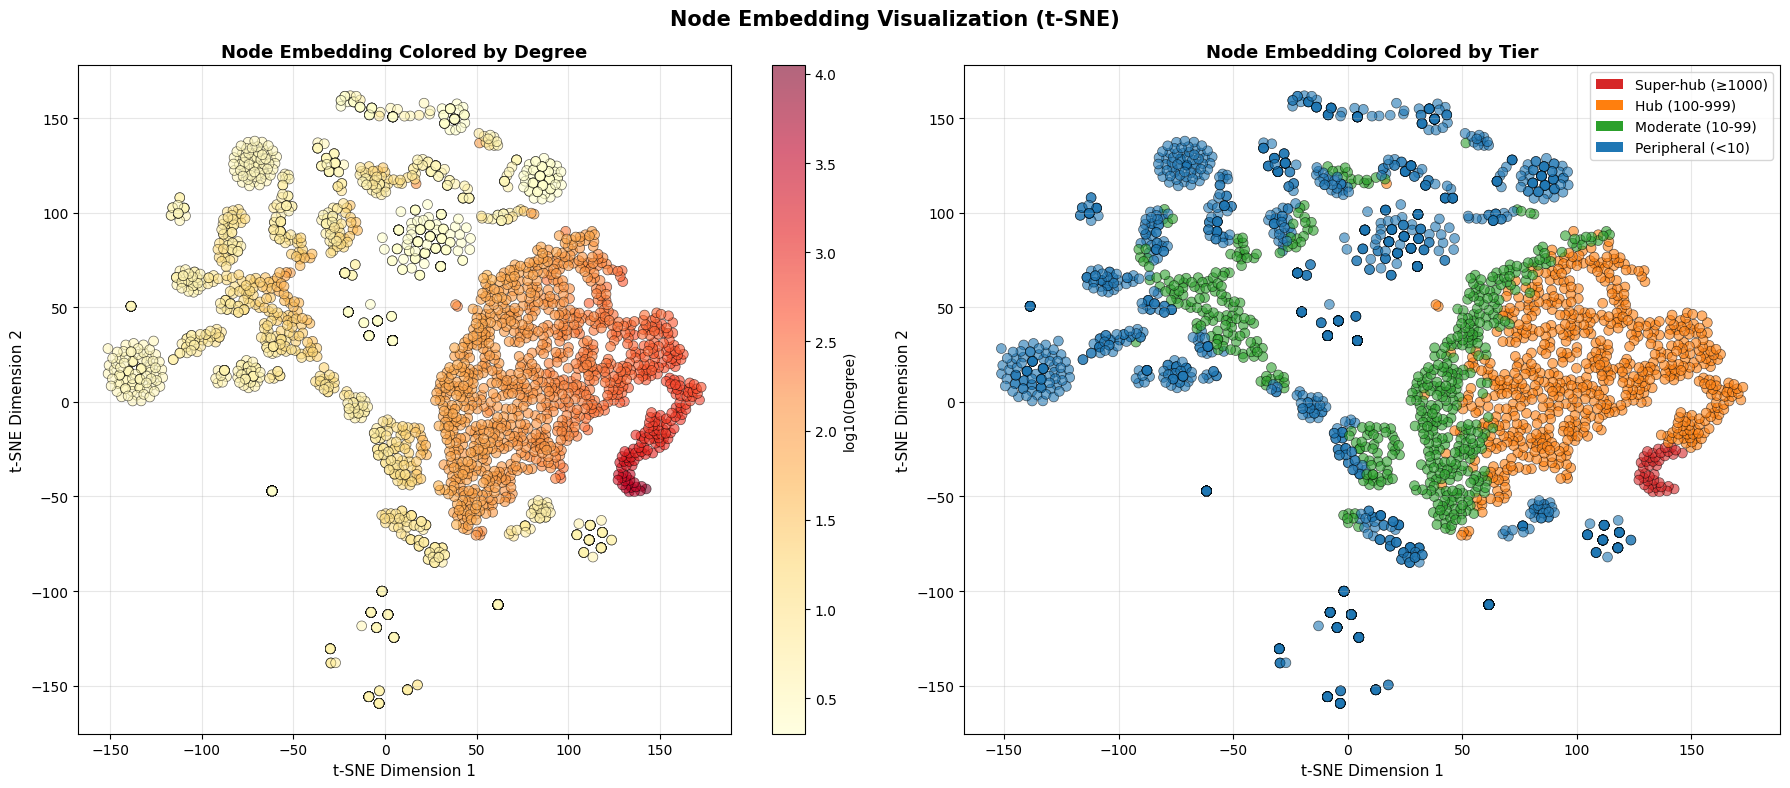

In [24]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

def visualize_node_embedding(G, sample_size=5000):
    """
    Use t-SNE to embed nodes in 2D, colored by degree tier.
    Shows clustering patterns beautifully!
    """
    from sklearn.manifold import TSNE
    from sklearn.preprocessing import StandardScaler
    import random
    
    print("Building node feature vectors...")
    
    # Get node degrees
    node_degrees = defaultdict(int)
    node_to_edges = defaultdict(set)
    
    for e in G.edges:
        for node in G.edges[e]:
            node_degrees[node] += 1
            node_to_edges[node].add(e)
    
    # Sample nodes (include all hubs + random others)
    hub_nodes = [n for n, d in sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)[:1000]]
    other_nodes = [n for n in G.nodes if n not in hub_nodes]
    sample_others = random.sample(other_nodes, min(sample_size - len(hub_nodes), len(other_nodes)))
    sampled_nodes = hub_nodes + sample_others
    
    print(f"Sampled {len(sampled_nodes)} nodes ({len(hub_nodes)} hubs + {len(sample_others)} others)")
    
    # Build feature vectors (simple: [degree, # neighbors, avg edge size])
    features = []
    for node in sampled_nodes:
        degree = node_degrees[node]
        edges = node_to_edges[node]
        neighbors = set()
        edge_sizes = []
        
        for e in edges:
            e_nodes = set(G.edges[e])
            neighbors.update(e_nodes)
            edge_sizes.append(len(e_nodes))
        
        features.append([
            degree,
            len(neighbors),
            np.mean(edge_sizes) if edge_sizes else 0
        ])
    
    features = np.array(features)
    
    # Standardize
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # t-SNE
    print("Running t-SNE (this may take a few minutes)...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    embedding = tsne.fit_transform(features_scaled)
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot 1: Colored by degree tier
    ax1 = axes[0]
    
    degrees = np.array([node_degrees[n] for n in sampled_nodes])
    colors = np.log10(degrees + 1)  # log scale for better colors
    
    scatter1 = ax1.scatter(
        embedding[:, 0], embedding[:, 1],
        c=colors, cmap='YlOrRd', s=50, alpha=0.6,
        edgecolors='black', linewidth=0.5
    )
    
    # *** REMOVED LABELING HERE ***  ← Removed top hub annotations
    
    plt.colorbar(scatter1, ax=ax1, label='log10(Degree)')
    ax1.set_title('Node Embedding Colored by Degree', fontsize=13, fontweight='bold')
    ax1.set_xlabel('t-SNE Dimension 1', fontsize=11)
    ax1.set_ylabel('t-SNE Dimension 2', fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Colored by tier (categorical)
    ax2 = axes[1]
    
    tier_colors = []
    for degree in degrees:
        if degree >= 1000:
            tier_colors.append('#d62728')
        elif degree >= 100:
            tier_colors.append('#ff7f0e')
        elif degree >= 10:
            tier_colors.append('#2ca02c')
        else:
            tier_colors.append('#1f77b4')
    
    scatter2 = ax2.scatter(
        embedding[:, 0], embedding[:, 1],
        c=tier_colors, s=50, alpha=0.6,
        edgecolors='black', linewidth=0.5
    )
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#d62728', label='Super-hub (≥1000)'),
        Patch(facecolor='#ff7f0e', label='Hub (100-999)'),
        Patch(facecolor='#2ca02c', label='Moderate (10-99)'),
        Patch(facecolor='#1f77b4', label='Peripheral (<10)')
    ]
    ax2.legend(handles=legend_elements, fontsize=10)
    
    ax2.set_title('Node Embedding Colored by Tier', fontsize=13, fontweight='bold')
    ax2.set_xlabel('t-SNE Dimension 1', fontsize=11)
    ax2.set_ylabel('t-SNE Dimension 2', fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Node Embedding Visualization (t-SNE)', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_node_embedding(G, sample_size=5000)

In [25]:
# Colored co-occurence? 

Computing hub co-occurrences...
  Processed 50000 edges...
  Processed 100000 edges...
  Processed 150000 edges...
  Processed 200000 edges...
  Processed 250000 edges...
  Processed 300000 edges...
Computing layout...


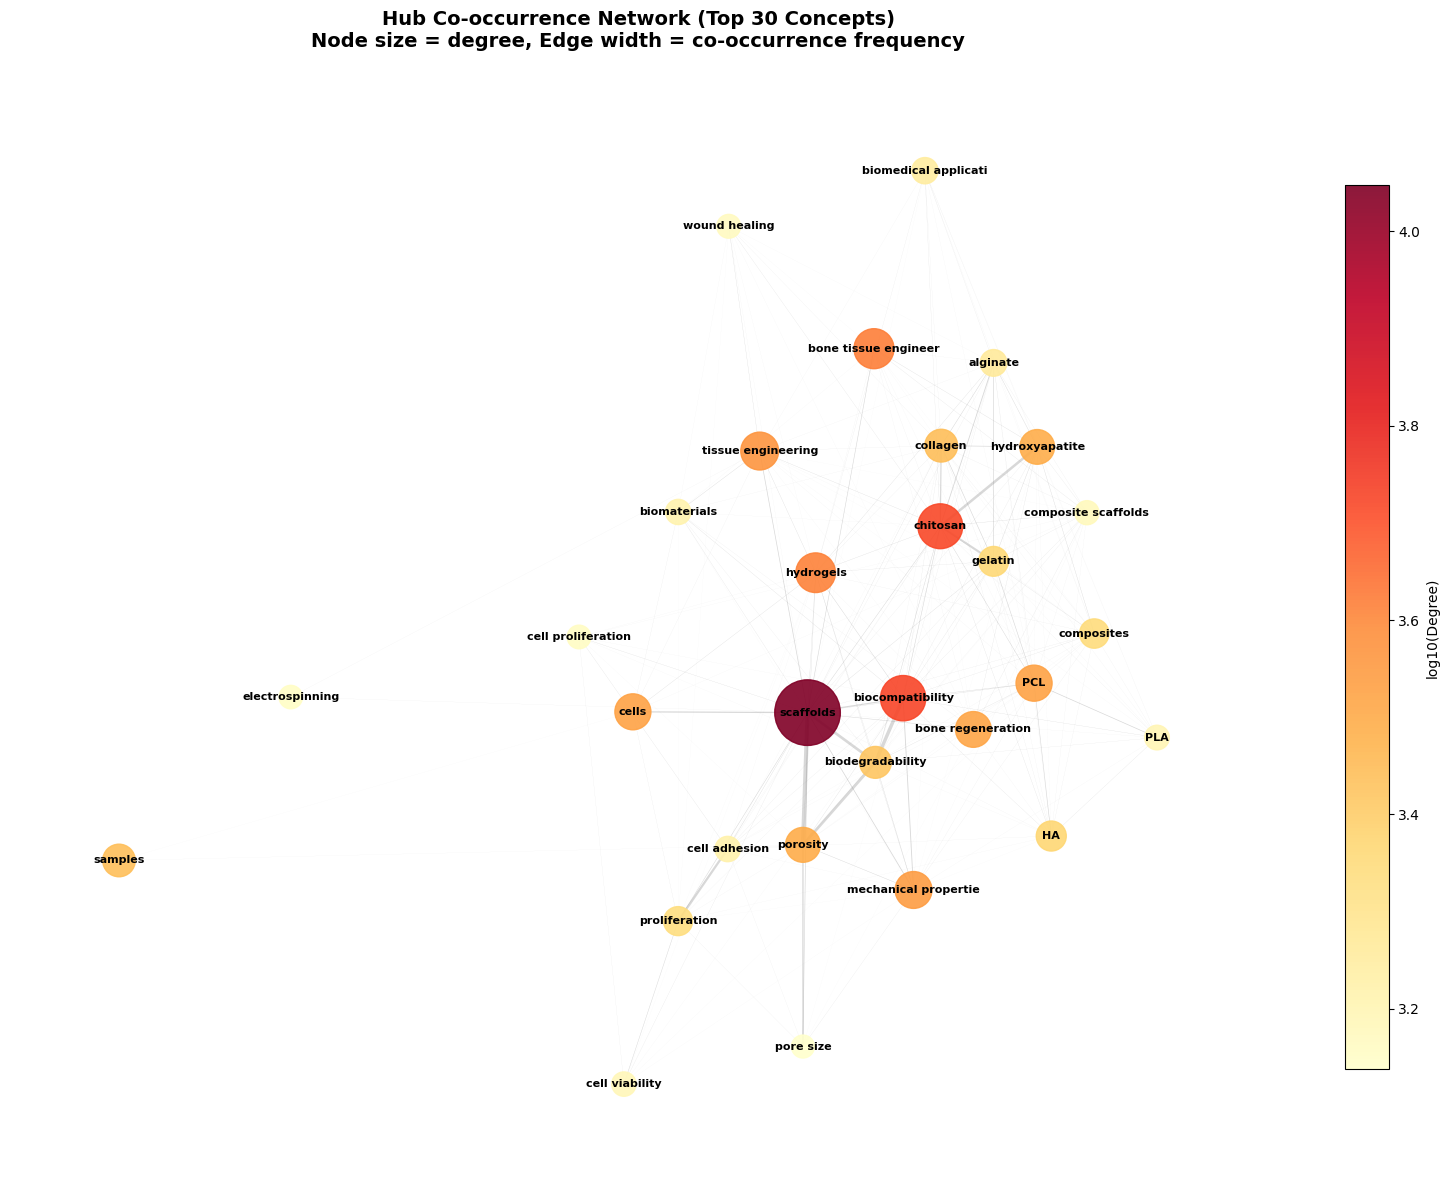


Network Statistics:
Nodes: 30
Edges: 207
Density: 0.476
Avg clustering: 0.647


In [26]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

def visualize_hub_cooccurrence_network(G, top_k=30):
    """
    Create a network of top hubs, colored by degree, connected by co-occurrence.
    Beautiful and informative!
    """
    # Get top hubs
    node_degrees = defaultdict(int)
    for e in G.edges:
        for node in G.edges[e]:
            node_degrees[node] += 1
    
    top_hubs = [n for n, d in sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)[:top_k]]
    hub_degrees = {n: node_degrees[n] for n in top_hubs}
    
    # Compute co-occurrence weights
    print("Computing hub co-occurrences...")
    cooccur = defaultdict(int)
    
    for i, e in enumerate(G.edges):
        if (i + 1) % 50000 == 0:
            print(f"  Processed {i+1} edges...")
        
        e_nodes = set(G.edges[e])
        hubs_in_edge = [h for h in top_hubs if h in e_nodes]
        
        for i in range(len(hubs_in_edge)):
            for j in range(i+1, len(hubs_in_edge)):
                pair = tuple(sorted([hubs_in_edge[i], hubs_in_edge[j]]))
                cooccur[pair] += 1
    
    # Build NetworkX graph
    hub_network = nx.Graph()
    
    # Add nodes with attributes
    for hub in top_hubs:
        hub_network.add_node(hub, degree=hub_degrees[hub])
    
    # Add edges with weights (only if co-occur > threshold)
    min_cooccur = 10  # Adjust for clarity
    for (h1, h2), weight in cooccur.items():
        if weight >= min_cooccur:
            hub_network.add_edge(h1, h2, weight=weight)
    
    # Layout
    print("Computing layout...")
    pos = nx.spring_layout(hub_network, k=2, iterations=50, seed=42)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Node colors based on degree (log scale for better visualization)
    node_colors = [np.log10(hub_degrees[n]) for n in hub_network.nodes()]
    
    # Node sizes based on degree
    node_sizes = [hub_degrees[n] / 5 for n in hub_network.nodes()]
    
    # Edge widths based on co-occurrence
    edges = hub_network.edges()
    weights = [hub_network[u][v]['weight'] for u, v in edges]
    max_weight = max(weights) if weights else 1
    edge_widths = [3 * w / max_weight for w in weights]
    
    # Draw edges
    nx.draw_networkx_edges(hub_network, pos, 
                          width=edge_widths, 
                          alpha=0.3,
                          edge_color='gray',
                          ax=ax)
    
    # Draw nodes
    nodes = nx.draw_networkx_nodes(hub_network, pos,
                                   node_color=node_colors,
                                   node_size=node_sizes,
                                   cmap='YlOrRd',
                                   alpha=0.9,
                                   ax=ax)
    
    # Draw labels (abbreviate long names)
    labels = {n: str(n)[:20] for n in hub_network.nodes()}
    nx.draw_networkx_labels(hub_network, pos, labels, 
                           font_size=8, font_weight='bold',
                           ax=ax)
    
    # Colorbar
    plt.colorbar(nodes, ax=ax, label='log10(Degree)', shrink=0.8)
    
    ax.set_title(f'Hub Co-occurrence Network (Top {top_k} Concepts)\n' + 
                 'Node size = degree, Edge width = co-occurrence frequency',
                 fontsize=14, fontweight='bold', pad=20)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nNetwork Statistics:")
    print(f"Nodes: {hub_network.number_of_nodes()}")
    print(f"Edges: {hub_network.number_of_edges()}")
    print(f"Density: {nx.density(hub_network):.3f}")
    print(f"Avg clustering: {nx.average_clustering(hub_network):.3f}")

visualize_hub_cooccurrence_network(G, top_k=30)

In [27]:
# Hub to Hub Co-Ocurrence 

In [28]:
def analyze_hub_cooccurrence(G, top_k=20):
    """
    How often do top hubs appear together in the same hyperedges?
    Reveals whether hubs form coherent research themes or are independent.
    """
    from collections import defaultdict
    import numpy as np
    
    # Get top hubs
    node_degrees = defaultdict(int)
    for e in G.edges:
        for node in G.edges[e]:
            node_degrees[node] += 1
    
    top_hubs = [n for n, d in sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)[:top_k]]
    
    # Build co-occurrence matrix
    cooccur = defaultdict(int)
    
    print(f"Computing co-occurrence for top {top_k} hubs...")
    for i, e in enumerate(G.edges):
        if (i + 1) % 50000 == 0:
            print(f"  Processed {i+1} edges...")
        
        e_nodes = set(G.edges[e])
        hubs_in_edge = [h for h in top_hubs if h in e_nodes]
        
        # Count pairs
        for i in range(len(hubs_in_edge)):
            for j in range(i+1, len(hubs_in_edge)):
                pair = tuple(sorted([hubs_in_edge[i], hubs_in_edge[j]]))
                cooccur[pair] += 1
    
    # Show top co-occurrences
    print("\nTop 15 Hub Pair Co-occurrences:")
    top_pairs = sorted(cooccur.items(), key=lambda x: x[1], reverse=True)[:15]
    
    for (hub1, hub2), count in top_pairs:
        print(f"  {str(hub1)[:30]} + {str(hub2)[:30]}: {count} edges")
    
    # Identify isolated vs. connected hubs
    hub_connections = defaultdict(int)
    for (h1, h2), count in cooccur.items():
        hub_connections[h1] += count
        hub_connections[h2] += count
    
    print("\nHub Integration Scores (total co-occurrences with other hubs):")
    for hub in sorted(hub_connections.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {str(hub[0])[:40]}: {hub[1]}")
    
    return cooccur

hub_cooccur = analyze_hub_cooccurrence(G, top_k=20)

Computing co-occurrence for top 20 hubs...
  Processed 50000 edges...
  Processed 100000 edges...
  Processed 150000 edges...
  Processed 200000 edges...
  Processed 250000 edges...
  Processed 300000 edges...

Top 15 Hub Pair Co-occurrences:
  porosity + scaffolds: 967 edges
  biocompatibility + biodegradability: 799 edges
  biodegradability + porosity: 651 edges
  biodegradability + scaffolds: 624 edges
  chitosan + hydroxyapatite: 589 edges
  chitosan + gelatin: 452 edges
  cells + scaffolds: 288 edges
  chitosan + collagen: 276 edges
  biocompatibility + scaffolds: 261 edges
  biocompatibility + mechanical properties: 200 edges
  alginate + chitosan: 193 edges
  mechanical properties + scaffolds: 177 edges
  scaffolds + tissue engineering: 161 edges
  alginate + gelatin: 157 edges
  collagen + hydroxyapatite: 153 edges

Hub Integration Scores (total co-occurrences with other hubs):
  scaffolds: 3335
  biodegradability: 2506
  chitosan: 2260
  biocompatibility: 1948
  porosity: 1942